In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

import xgboost as xgb
from sklearn.model_selection import cross_val_score
from bayes_opt import BayesianOptimization
from sklearn.linear_model.logistic import LogisticRegression
from sklearn.metrics import (accuracy_score, log_loss, classification_report)
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction import DictVectorizer

pd.options.display.max_columns = 120
pd.options.display.max_rows = 120

## 0.Data Preprocessing

In [35]:
# Plot styling and display options
sns.set(style='white', context='notebook', palette='deep')
plt.rcParams[ 'figure.figsize' ] = 10 , 6

pd.set_option('display.max_columns', 100) # Print 100 Pandas columns

In [36]:
train=pd.read_csv('train.csv',index_col=0)
test=pd.read_csv('test.csv',index_col=0)

In [37]:
# 处理Attrition字段
train['Attrition']=train['Attrition'].map(lambda x:1 if x=='Yes' else 0)
test['Attrition'] = -1
test = test[train.columns]
data = pd.concat([train, test])

In [38]:
data.columns

Index(['Age', 'Attrition', 'BusinessTravel', 'DailyRate', 'Department',
       'DistanceFromHome', 'Education', 'EducationField', 'EmployeeCount',
       'EmployeeNumber', 'EnvironmentSatisfaction', 'Gender', 'HourlyRate',
       'JobInvolvement', 'JobLevel', 'JobRole', 'JobSatisfaction',
       'MaritalStatus', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked',
       'Over18', 'OverTime', 'PercentSalaryHike', 'PerformanceRating',
       'RelationshipSatisfaction', 'StandardHours', 'StockOptionLevel',
       'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance',
       'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion',
       'YearsWithCurrManager'],
      dtype='object')

In [39]:
# Looking for NaN
display(data.isnull().any())

Age                         False
Attrition                   False
BusinessTravel              False
DailyRate                   False
Department                  False
DistanceFromHome            False
Education                   False
EducationField              False
EmployeeCount               False
EmployeeNumber              False
EnvironmentSatisfaction     False
Gender                      False
HourlyRate                  False
JobInvolvement              False
JobLevel                    False
JobRole                     False
JobSatisfaction             False
MaritalStatus               False
MonthlyIncome               False
MonthlyRate                 False
NumCompaniesWorked          False
Over18                      False
OverTime                    False
PercentSalaryHike           False
PerformanceRating           False
RelationshipSatisfaction    False
StandardHours               False
StockOptionLevel            False
TotalWorkingYears           False
TrainingTimesL

## 1. Feature Engineering

In [40]:
# 0 drop
# EmployeeCount, EmployeeNumber, StandardHours
data = data.drop(['EmployeeNumber', 'StandardHours', 'EmployeeCount'], axis=1)

In [41]:
# 1. Special features -- case by case
# Age
data['Age_band'] = pd.cut(data['Age'], 5)
lb_age = LabelEncoder()
lb_age.fit(data['Age_band'])
data['Age_band'] = lb_age.transform(data['Age_band'])       

In [42]:
# 2. label/Onehot Encode or factorize directly
# Onehot
# BusineessTravel, Department, EducationField, Gender, MaritalStatus, Over18, OverTime
onehot_list = ['BusinessTravel','Department','EducationField', 'Gender', 'MaritalStatus', 'Over18', 'OverTime']
for onehot in onehot_list:
    data = data.join(pd.get_dummies(data[[onehot]]))
    data = data.drop([onehot], axis = 1)
# Label or factorize
# JobRole
label_list = ['JobRole']
for label in label_list:
    data[label] = pd.factorize(data[label])[0]

In [43]:
# 3. Remain unchanged
# Daily Rate -- income
# DistanceFromHome -- distance
# HourlyRate
# Education
# EnvironmentSatisfaction
# MonthlyIncome
# PercentSalaryHike
# PerformanceRating
# RelationshipSatisfaction
# StockOptionLevel
# TotalWorkingYears
# TrainingTimesLastYear
# WorkLifeBalance
# YearsAtCompany
# YearsInCurrentRole
# YearsSinceLastPromotion
# YearsWithCurrManager

In [44]:
# 4. Further application
# Education DistanceFromHome, EducationField
# JobInvolvement, JobLevel, JobSatisfaction

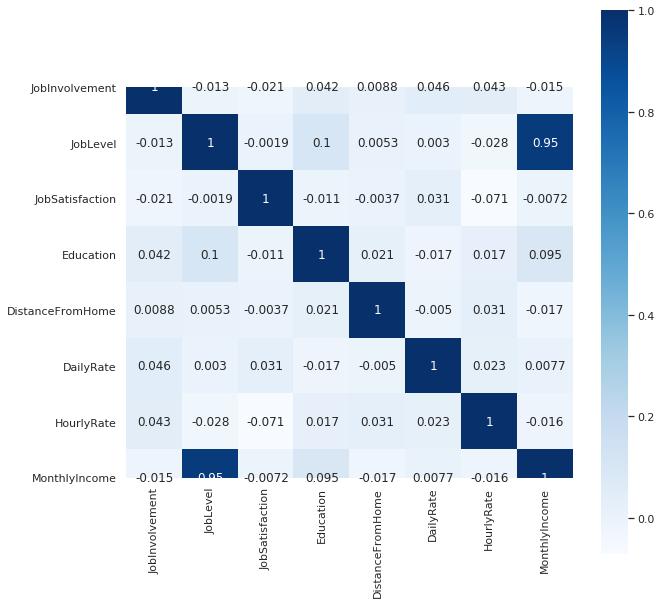

In [45]:
plt.figure(figsize = (10, 10))
sns.heatmap(data[['JobInvolvement', 'JobLevel', 'JobSatisfaction', 'Education', 'DistanceFromHome', 'DailyRate', 'HourlyRate', 'MonthlyIncome']].corr(), annot=True, vmax=1, square=True, cmap="Blues")

In [46]:
# feature importance
def show_feature_importance(feature_list, feature_importance):
	# 设定阈值
	fi_threshold = 20
	# 重要特征的下标
	important_idx = np.where(feature_importance > fi_threshold)[0]
	# 特征名称
	important_features = [feature_list[i] for i in important_idx]
	# 重要特征
	sorted_idx = np.argsort(feature_importance[important_idx])[::-1]
	# 可视化
	pos = np.arange(sorted_idx.shape[0]) + 0.5
	plt.subplot(1, 2, 2)
	plt.title('Feature Importance')
	plt.barh(pos, feature_importance[important_idx][sorted_idx[::-1]], color='r',align='center')
	plt.yticks(pos, [important_features[i] for i in sorted_idx[::-1]])
	plt.xlabel('Relative Importance')
	plt.draw()
	plt.show()

In [ ]:
model = LogisticRegression(max_iter=100, verbose=True, random_state=33, tol=1e-4)
model.fit(data[data.Attrition != -1].drop('Attrition', axis = 1), data[data.Attrition != -1]['Attrition'])
dvec=DictVectorizer(sparse=True)
# 获取特征重要性
feature_importance = coef = model.coef_[0]
feature_importance = 100.0 * (feature_importance / feature_importance.max())
#feature_importance = -100.0 * (feature_importance / feature_importance.max())
print(feature_importance)
# 重要特征可视化
show_feature_importance(dvec.feature_names_, feature_importance)

In [48]:
train = data[data.Attrition != -1]
test = data[data.Attrition == -1]

In [49]:
# SMOTE deal with imbalanced dataset
oversampler=SMOTE(random_state=0)
train, smote_target = oversampler.fit_sample(train.drop('Attrition', axis = 1),train['Attrition'])

## 2.Modeling

In [50]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
param = {'boosting_type':'gbdt',
                         'objective':'binary',
                         'metric':'auc',
                         'learning_rate':0.01,
                         'max_depth':15,
                         'feature_fraction':0.8,
                         'bagging_fraction':0.9,
                         'bagging_freq':8,
                         'lambda_l1':0.6,
                         'lambda_l2':0
        }
X_train, X_valid, y_train, y_valid = train_test_split(train, smote_target, test_size = 0.2, random_state = 55)
train_data = lgb.Dataset(X_train, label = y_train)
valid_data = lgb.Dataset(X_valid, label = y_valid)

model = lgb.train(param, train_data, valid_sets=[train_data, valid_data], num_boost_round = 10000, early_stopping_rounds = 200,\
                 verbose_eval = 25)
test[['Attrition']] = test[['Attrition']].astype(float)
predict_data = model.predict(test.drop('Attrition', axis = 1))
test['Attrition'] = predict_data
#test['Atrrition'] = test['Attrition'].map(lambda x:1 if x >= 0.5 else 0)
test[['Attrition']].to_csv('submit_lgb.csv')

Training until validation scores don't improve for 200 rounds
[25]	training's auc: 0.985714	valid_1's auc: 0.956454
[50]	training's auc: 0.987306	valid_1's auc: 0.958393
[75]	training's auc: 0.988954	valid_1's auc: 0.961224
[100]	training's auc: 0.990916	valid_1's auc: 0.961811
[125]	training's auc: 0.99275	valid_1's auc: 0.962092
[150]	training's auc: 0.994036	valid_1's auc: 0.964031
[175]	training's auc: 0.995235	valid_1's auc: 0.966276
[200]	training's auc: 0.996007	valid_1's auc: 0.967117
[225]	training's auc: 0.996775	valid_1's auc: 0.968036
[250]	training's auc: 0.997499	valid_1's auc: 0.968316
[275]	training's auc: 0.998161	valid_1's auc: 0.969872
[300]	training's auc: 0.998668	valid_1's auc: 0.97051
[325]	training's auc: 0.999037	valid_1's auc: 0.970842
[350]	training's auc: 0.999305	valid_1's auc: 0.971378
[375]	training's auc: 0.999503	valid_1's auc: 0.972423
[400]	training's auc: 0.999675	valid_1's auc: 0.972704
[425]	training's auc: 0.999771	valid_1's auc: 0.972806
[450]	tr

In [ ]:
def xgb_cv(n_estimators,learning_rate,max_depth,min_child_weigth,gamma,subsample,colsample_bytree,reg_alpha,reg_lambda):
    val = cross_val_score(    xgb.XGBClassifier( boosting_type='gbdt',
                                            objective= 'binary:logistic',
                                            n_estimators=int(n_estimators),
                                            learning_rate=learning_rate,
                                            max_depth=int(max_depth),
                                            min_child_weigth=min_child_weigth,
                                            gamma=gamma,
                                            subsamples=subsample,
                                            colsample_bytree=colsample_bytree,
                                            reg_alpha=reg_alpha,
                                            reg_lambda=reg_lambda),
                               train, 
                               smote_target,
                               scoring='roc_auc',
                               cv=5).mean()
    return val
xgb_bayes = BayesianOptimization(   xgb_cv,
                                    {'n_estimators':(20,500),
                                     'learning_rate':(0,0.5),
                                     'max_depth':(3,20),
                                     'min_child_weigth':(1,10),
                                     'gamma':(0,3),
                                     'subsample':(0.5,1),
                                     'colsample_bytree':(0.6,1),
                                     'reg_alpha':(0,5),
                                     'reg_lambda':(0,5)})
xgb_bayes.maximize()     #开始训练
result = xgb_bayes.max     #得到最佳分数以及最佳分数对应的参数，为字典类型

|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | n_esti... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------
|  1        |  0.9686   |  0.7633   |  1.909    |  0.3687   |  7.932    |  5.19     |  446.0    |  3.246    |  4.408    |  0.9058   |
|  2        |  0.9622   |  0.6783   |  1.165    |  0.09129  |  5.398    |  5.71     |  26.14    |  4.697    |  2.185    |  0.6308   |
|  3        |  0.9691   |  0.8853   |  1.153    |  0.3525   |  6.125    |  5.059    |  414.9    |  1.079    |  2.592    |  0.931    |
|  4        |  0.9722   |  0.6115   |  1.869    |  0.03115  |  13.91    |  1.921    |  196.0    |  1.86     |  0.2083   |  0.5623   |
|  5        |  0.9662   |  0.8759   |  1.6      |  0.4359   |  17.62    |  3.742    |  487.4    |  3.601    |  1.046    |  0.5173   |
|  6        |  0.9724   |  0.9875   |  0.3941   |  0.09558  | 

In [51]:
result 

{'target': 0.9789979215836777,
 'params': {'colsample_bytree': 0.6358445534636434,
  'gamma': 0.043765032970644824,
  'learning_rate': 0.19380913874122668,
  'max_depth': 19.792051191051915,
  'min_child_weigth': 9.352771844758424,
  'n_estimators': 201.72666849569,
  'reg_alpha': 0.6325077849536054,
  'reg_lambda': 0.19417376628919236,
  'subsample': 0.9820534523924532}}

In [71]:
xgboost = xgb.XGBClassifier(boosting_type='gbdt', objective= 'binary:logistic', params = result['params'])

In [72]:
xgboost.fit(train, smote_target)
attrition = xgboost.predict_proba(test.drop('Attrition', axis = 1))

In [73]:
attrition = [attrition[i][1] for i in range(len(attrition))]

In [74]:
test['Attrition'] = attrition
#test['Atrrition'] = test['Attrition'].map(lambda x:1 if x >= 0.5 else 0)
test[['Attrition']].to_csv('submit_xgb.csv')

In [25]:
xgb_clf = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                           colsample_bytree=0.8, gamma=1.5, learning_rate=0.05,
                           max_delta_step=0, max_depth=3, min_child_weight=7, missing=None,
                           n_estimators=200, n_jobs=-1, nthread=None,
                           objective='binary:logistic', random_state=0, reg_alpha=0,
                           reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
                           subsample=0.6)

xgb_clf.fit(train, smote_target)
y_pred = xgb_clf.predict(test.drop('Attrition', axis = 1))
y_score = xgb_clf.predict_proba(test.drop('Attrition', axis = 1))[:,1]

In [26]:
test['Attrition'] = y_score
#test['Atrrition'] = test['Attrition'].map(lambda x:1 if x >= 0.5 else 0)
test[['Attrition']].to_csv('submit_xgb_smote.csv')

In [56]:
train

,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MonthlyIncome,MonthlyRate,NumCompaniesWorked,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Age_band,BusinessTravel_Non-Travel,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,Department_Human Resources,Department_Research & Development,Department_Sales,EducationField_Human Resources,EducationField_Life Sciences,EducationField_Marketing,EducationField_Medical,EducationField_Other,EducationField_Technical Degree,Gender_Female,Gender_Male,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,Over18_Y,OverTime_No,OverTime_Yes
0,58,605,21,3,4,72,3,4,0,4,17875,11761,4,13,3,3,1,29,2,2,1,0,0,0,4,0,0,1,0,0,1,0,1,0,0,0,0,1,0,0,1,0,1,0,1
1,45,950,28,3,4,97,3,1,1,4,2132,4585,4,20,4,4,1,8,3,3,5,4,0,3,3,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,1,0,1,1,0
2,40,300,26,3,3,74,3,2,2,1,8396,22217,1,14,3,2,1,8,3,2,7,7,7,5,2,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,1,0,1,1,0
3,36,1434,8,4,1,76,2,3,2,1,7587,14229,1,15,3,2,0,10,1,3,10,7,0,9,2,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,1,1,0
4,25,599,24,1,3,73,1,1,3,4,1118,8040,1,14,3,4,0,1,4,3,1,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1971,41,619,1,4,1,54,2,3,2,3,10486,14837,3,12,3,2,0,21,2,1,19,2,8,7,2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0
1972,29,448,5,3,2,42,2,1,1,3,2291,3389,8,21,3,3,0,3,3,3,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1
1973,30,410,22,3,1,56,3,3,6,3,9171,23390,2,14,3,1,0,11,2,2,3,1,0,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0
1974,38,858,13,3,2,57,2,1,1,3,1927,15749,5,14,3,3,0,4,3,2,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0


In [63]:
train.columns[24:45]

Index(['Age_band', 'BusinessTravel_Non-Travel',
       'BusinessTravel_Travel_Frequently', 'BusinessTravel_Travel_Rarely',
       'Department_Human Resources', 'Department_Research & Development',
       'Department_Sales', 'EducationField_Human Resources',
       'EducationField_Life Sciences', 'EducationField_Marketing',
       'EducationField_Medical', 'EducationField_Other',
       'EducationField_Technical Degree', 'Gender_Female', 'Gender_Male',
       'MaritalStatus_Divorced', 'MaritalStatus_Married',
       'MaritalStatus_Single', 'Over18_Y', 'OverTime_No', 'OverTime_Yes'],
      dtype='object')

In [69]:
import numpy as np
import catboost as cb

model = cb.CatBoostClassifier(iterations=10000,
         od_type='Iter',
         od_wait=120,
         max_depth=8,
         learning_rate=0.02,
         l2_leaf_reg=9,
         random_seed=2018,
         metric_period=50,
         fold_len_multiplier=1.1,
         loss_function='Logloss',
         logging_level='Verbose')
model.fit(train, smote_target, cat_features=[8, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34 ,35, 36, 37, 38, 39, 40, 41, 42, 43, 44])
preds_class = model.predict(test.drop('Attrition', axis = 1))
preds_probs = model.predict_proba(test.drop('Attrition', axis = 1))
#print('class = ',preds_class)
#print('proba = ',preds_probs)
test['Attrition'] = preds_probs[:, 1]
#test['Atrrition'] = test['Attrition'].map(lambda x:1 if x >= 0.5 else 0)
test[['Attrition']].to_csv('submit_cat_smote.csv')

0:	learn: 0.6777773	total: 44.5ms	remaining: 7m 24s
50:	learn: 0.3253175	total: 1.58s	remaining: 5m 8s
100:	learn: 0.2265523	total: 3.13s	remaining: 5m 7s
150:	learn: 0.1805508	total: 4.9s	remaining: 5m 19s
200:	learn: 0.1507049	total: 6.4s	remaining: 5m 12s
250:	learn: 0.1285619	total: 8.19s	remaining: 5m 17s
300:	learn: 0.1126945	total: 9.96s	remaining: 5m 20s
350:	learn: 0.0985176	total: 11.6s	remaining: 5m 19s
400:	learn: 0.0865151	total: 13.1s	remaining: 5m 14s
450:	learn: 0.0754773	total: 14.6s	remaining: 5m 8s
500:	learn: 0.0660682	total: 16s	remaining: 5m 3s
550:	learn: 0.0583678	total: 17.3s	remaining: 4m 57s
600:	learn: 0.0518513	total: 18.6s	remaining: 4m 51s
650:	learn: 0.0466991	total: 20s	remaining: 4m 46s
700:	learn: 0.0423765	total: 21.3s	remaining: 4m 42s
750:	learn: 0.0385214	total: 22.6s	remaining: 4m 37s
800:	learn: 0.0353241	total: 23.9s	remaining: 4m 34s
850:	learn: 0.0324574	total: 25.3s	remaining: 4m 31s
900:	learn: 0.0298495	total: 26.6s	remaining: 4m 28s
950:	

In [77]:
score = [attrition[i] * 0.3 + preds_probs[:, 1][i] * 0.7 for i in range(len(attrition))]

In [80]:
test['Attrition'] = score
#test['Atrrition'] = test['Attrition'].map(lambda x:1 if x >= 0.5 else 0)
test[['Attrition']].to_csv('submit_cat_xgv_smote.csv')